# **Library**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import shutil
import random
import zipfile
from PIL import Image
import glob
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate, GlobalAveragePooling2D

# **Data Loading**

In [ ]:
folder_path = 'chili dataset augmented'

In [ ]:
# Fungsi untuk menghitung jumlah file dalam setiap subfolder
def count_files_in_subfolders(path):
    file_counts = {}

    # Loop melalui setiap subfolder dalam folder utama
    for root, dirs, files in os.walk(path):
        for dir_name in dirs:
            # Mendapatkan path lengkap ke subfolder
            subfolder_path = os.path.join(root, dir_name)
            # Menghitung jumlah file dalam subfolder
            file_count = len([f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))])
            file_counts[subfolder_path] = file_count

    return file_counts

# Menghitung jumlah file dalam setiap subfolder
file_counts = count_files_in_subfolders(folder_path)

# Menampilkan jumlah file dalam setiap subfolder
for subfolder, count in file_counts.items():
    print(f'Jumlah file di "{subfolder}": {count}')

Jumlah file di "chili dataset augmented/test": 0
Jumlah file di "chili dataset augmented/train": 0
Jumlah file di "chili dataset augmented/test/healthy": 1010
Jumlah file di "chili dataset augmented/test/mites_and_trips": 1291
Jumlah file di "chili dataset augmented/test/nutritional": 945
Jumlah file di "chili dataset augmented/test/powdery mildew": 944
Jumlah file di "chili dataset augmented/test/cercospora": 1164
Jumlah file di "chili dataset augmented/train/healthy": 1188
Jumlah file di "chili dataset augmented/train/mites_and_trips": 1216
Jumlah file di "chili dataset augmented/train/nutritional": 1087
Jumlah file di "chili dataset augmented/train/powdery mildew": 1087
Jumlah file di "chili dataset augmented/train/cercospora": 1055


In [ ]:
def check_image_dimensions(folder_path):
    # Get all image paths
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_paths = []

    for root, _, files in os.walk(folder_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_paths.append(os.path.join(root, file))

    # Check dimensions of first 20 images (adjust as needed)
    dimensions = set()
    for img_path in image_paths[:20]:
        try:
            img = tf.io.read_file(img_path)
            img = tf.image.decode_image(img, channels=3)  # Automatically detects format
            dimensions.add(img.shape[:2])  # (height, width)
        except:
            print(f"Error reading: {img_path}")
            continue

    print(f"Unique dimensions found: {dimensions}")
    return dimensions

check_image_dimensions(folder_path)

Unique dimensions found: {TensorShape([256, 256])}


{TensorShape([256, 256])}

In [ ]:
# Define paths
dataset_dir = "chili dataset augmented"
combined_dir = os.path.join(dataset_dir, "combined")

# Create combined directory
os.makedirs(combined_dir, exist_ok=True)

# List of classes
class_names = ['healthy', 'mites_and_trips', 'nutritional', 'powdery mildew', 'cercospora']

# Source directories to merge
source_dirs = ["train", "test", "val"]

for cls in class_names:
    # Create class folder in combined dir
    combined_cls_dir = os.path.join(combined_dir, cls)
    os.makedirs(combined_cls_dir, exist_ok=True)

    for src in source_dirs:
        src_folder = os.path.join(dataset_dir, src, cls)

        if not os.path.exists(src_folder):
            print(f"Warning: {src_folder} does not exist. Skipping.")
            continue

        # Get all image files
        files = glob.glob(os.path.join(src_folder, "*.*"))

        # Move each file to combined folder
        for f in files:
            filename = os.path.basename(f)
            dest_path = os.path.join(combined_cls_dir, filename)
            shutil.move(f, dest_path)  # Use shutil.copy(f, dest_path) to keep originals

    print(f"Combined all images for class '{cls}' into {combined_cls_dir}")

Combined all images for class 'healthy' into chili dataset augmented/combined/healthy
Combined all images for class 'mites_and_trips' into chili dataset augmented/combined/mites_and_trips
Combined all images for class 'nutritional' into chili dataset augmented/combined/nutritional
Combined all images for class 'powdery mildew' into chili dataset augmented/combined/powdery mildew
Combined all images for class 'cercospora' into chili dataset augmented/combined/cercospora


In [ ]:
# Define paths
dataset_dir = "aug chili dataset"          # Folder containing class folders
output_dir = "aug_dataset_split"     # Output directory for train/val/test

# Create output directories
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Ratio: 70% train, 15% val, 15% test
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

# Get list of classes
class_names = os.listdir(dataset_dir)
class_names = [d for d in class_names if os.path.isdir(os.path.join(dataset_dir, d))]

for cls in class_names:
    # Create class directories in train, val, test
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Get all image files
    src_dir = os.path.join(dataset_dir, cls)
    files = glob.glob(os.path.join(src_dir, "*.*"))
    random.shuffle(files)

    # Calculate split indices
    total = len(files)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    # Copy files
    for f in train_files:
        dest = os.path.join(train_dir, cls, os.path.basename(f))
        shutil.copy(f, dest)

    for f in val_files:
        dest = os.path.join(val_dir, cls, os.path.basename(f))
        shutil.copy(f, dest)

    for f in test_files:
        dest = os.path.join(test_dir, cls, os.path.basename(f))
        shutil.copy(f, dest)

    print(f"{cls}: Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)}")

healthy: Train=1536, Val=329, Test=330
mites_and_trips: Train=1752, Val=375, Test=377
nutritional: Train=1420, Val=304, Test=305
powdery mildew: Train=1420, Val=304, Test=305
cercospora: Train=1551, Val=332, Test=334


In [ ]:
# Tentukan folder output untuk hasil pembagian dataset
output_base_path = 'aug_dataset_split'

In [ ]:
# Fungsi untuk menghitung jumlah file per kelas dalam setiap subset (train, val, test)
def count_files_per_class(subset_path):
    class_counts = {}
    # Loop melalui setiap kelas dalam subset (train, val, test)
    for class_folder in os.listdir(subset_path):
        class_path = os.path.join(subset_path, class_folder)
        if os.path.isdir(class_path):  # Pastikan hanya folder kelas yang diproses
            # Menghitung jumlah file dalam folder kelas
            class_file_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_folder] = class_file_count
    return class_counts

# Hitung jumlah file per kelas untuk train, val, dan test
train_class_counts = count_files_per_class(os.path.join(output_base_path, 'train'))
val_class_counts = count_files_per_class(os.path.join(output_base_path, 'val'))
test_class_counts = count_files_per_class(os.path.join(output_base_path, 'test'))

# Menampilkan jumlah file per kelas untuk setiap subset
print("Jumlah file per kelas di subset train:")
for class_name, count in train_class_counts.items():
    print(f"  Kelas '{class_name}': {count} file")

print("\nJumlah file per kelas di subset val:")
for class_name, count in val_class_counts.items():
    print(f"  Kelas '{class_name}': {count} file")

print("\nJumlah file per kelas di subset test:")
for class_name, count in test_class_counts.items():
    print(f"  Kelas '{class_name}': {count} file")

Jumlah file per kelas di subset train:
  Kelas 'healthy': 1536 file
  Kelas 'mites_and_trips': 1752 file
  Kelas 'nutritional': 1420 file
  Kelas 'powdery mildew': 1420 file
  Kelas 'cercospora': 1551 file

Jumlah file per kelas di subset val:
  Kelas 'healthy': 329 file
  Kelas 'mites_and_trips': 375 file
  Kelas 'nutritional': 304 file
  Kelas 'powdery mildew': 304 file
  Kelas 'cercospora': 332 file

Jumlah file per kelas di subset test:
  Kelas 'healthy': 330 file
  Kelas 'mites_and_trips': 377 file
  Kelas 'nutritional': 305 file
  Kelas 'powdery mildew': 305 file
  Kelas 'cercospora': 334 file


# **Data Preprocessing**

In [ ]:
# Define paths
train_dir = 'aug_dataset_split/train'
val_dir = 'aug_dataset_split/val'
test_dir = 'aug_dataset_split/test'

In [ ]:
# Image dimensions
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)


Found 7679 files belonging to 5 classes.
Found 1644 files belonging to 5 classes.
Found 1651 files belonging to 5 classes.


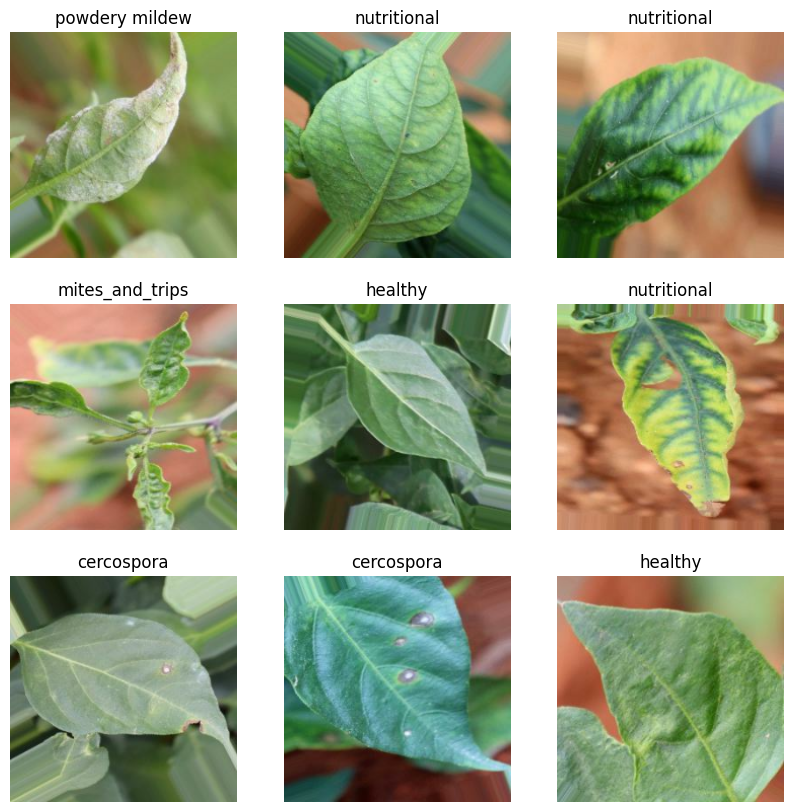

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
def preprocess_labels(images, labels):
  """Preprocess the labels to one-hot encode them."""
  labels = to_categorical(labels, num_classes=5)
  return images, labels

train_dataset = train_dataset.map(preprocess_labels)
val_dataset = val_dataset.map(preprocess_labels)
test_dataset = test_dataset.map(preprocess_labels)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# **Model Training**

## **Model Initiation**

In [ ]:
vgg16_base = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
resnet50_base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [ ]:
vgg16_base.trainable = False
resnet50_base.trainable = False

In [ ]:
inputs = Input(shape=(224, 224, 3))
vgg16_features = vgg16_base(inputs)
resnet50_features = resnet50_base(inputs)

In [ ]:
vgg16_pooled = GlobalAveragePooling2D()(vgg16_features)
resnet50_pooled = GlobalAveragePooling2D()(resnet50_features)

## **Hybrid**

In [ ]:
merged_features = Concatenate()([vgg16_pooled, resnet50_pooled])

In [ ]:
x = Dense(128, activation='relu')(merged_features)
x = Dense(64, activation='relu')(x)
x = Dense(5, activation='softmax')(x)

In [ ]:
model = Model(inputs, x)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_11[0… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 2560)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 128)       │    327,808 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │      8,256 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 5)         │        325 │ dense_22[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,638,789 (147.40 MB)

 Trainable params: 336,389 (1.28 MB)

 Non-trainable params: 38,302,400 (146.11 MB)

In [ ]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.7206 - loss: 0.8693 - val_accuracy: 0.9033 - val_loss: 0.2825
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.9372 - loss: 0.1877 - val_accuracy: 0.9264 - val_loss: 0.1812
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.9730 - loss: 0.0873 - val_accuracy: 0.9726 - val_loss: 0.0844
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.9848 - loss: 0.0407 - val_accuracy: 0.9684 - val_loss: 0.0878
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.9754 - loss: 0.0628 - val_accuracy: 0.9659 - val_loss: 0.0839
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.9898 - loss: 0.0314 - val_accuracy: 0.9684 - val_loss: 0.0890
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.9930 - loss: 0.0210 - val_accuracy: 0.9793 - val_loss: 0.0547
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.9936 - loss: 0.0195 - val_accu

## **VGG16**

In [ ]:
vgg16 = Dense(128, activation='relu')(vgg16_pooled)
vgg16 = Dense(64, activation='relu')(vgg16)
vgg16 = Dense(5, activation='softmax')(vgg16)

In [ ]:
model_vgg16 = Model(inputs, vgg16)

In [ ]:
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_vgg16.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,788,933 (56.42 MB)

 Trainable params: 74,245 (290.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
initial_epochs = 10

history_vgg16 = model_vgg16.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 221s 919ms/step - accuracy: 0.6198 - loss: 1.1914 - val_accuracy: 0.8230 - val_loss: 0.4691
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 220s 917ms/step - accuracy: 0.9041 - loss: 0.2872 - val_accuracy: 0.9051 - val_loss: 0.2519
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 218s 910ms/step - accuracy: 0.9531 - loss: 0.1568 - val_accuracy: 0.9392 - val_loss: 0.1730
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 219s 912ms/step - accuracy: 0.9709 - loss: 0.0932 - val_accuracy: 0.9489 - val_loss: 0.1504
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 218s 910ms/step - accuracy: 0.9845 - loss: 0.0522 - val_accuracy: 0.9532 - val_loss: 0.1349
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 218s 911ms/step - accuracy: 0.9888 - loss: 0.0383 - val_accuracy: 0.9507 - val_loss: 0.1507
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 218s 909ms/step - accuracy: 0.9925 - loss: 0.0259 - val_accuracy: 0.9611 - val_loss: 0.1190
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 218s 910ms/step - accuracy: 0.9959 -

## **ResNet50**

In [ ]:
resnet50 = Dense(128, activation='relu')(resnet50_pooled)
resnet50 = Dense(64, activation='relu')(resnet50)
resnet50 = Dense(5, activation='softmax')(resnet50)

In [ ]:
model_resnet50 = Model(inputs, resnet50)

In [ ]:
model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_resnet50.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,565 (91.01 MB)

 Trainable params: 270,853 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
initial_epochs = 10

history_resnet50 = model_resnet50.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 127s 520ms/step - accuracy: 0.7303 - loss: 0.7432 - val_accuracy: 0.9082 - val_loss: 0.2568
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 123s 515ms/step - accuracy: 0.9379 - loss: 0.1884 - val_accuracy: 0.9380 - val_loss: 0.1681
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 121s 506ms/step - accuracy: 0.9696 - loss: 0.0949 - val_accuracy: 0.9678 - val_loss: 0.1032
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 122s 508ms/step - accuracy: 0.9821 - loss: 0.0580 - val_accuracy: 0.9702 - val_loss: 0.0828
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 121s 505ms/step - accuracy: 0.9887 - loss: 0.0367 - val_accuracy: 0.9215 - val_loss: 0.2336
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 122s 510ms/step - accuracy: 0.9799 - loss: 0.0609 - val_accuracy: 0.9714 - val_loss: 0.0732
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 121s 503ms/step - accuracy: 0.9964 - loss: 0.0136 - val_accuracy: 0.9781 - val_loss: 0.0679
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 121s 504ms/step - accuracy: 0.9978 -

# **Model Evaluation**

## **Hybrid**

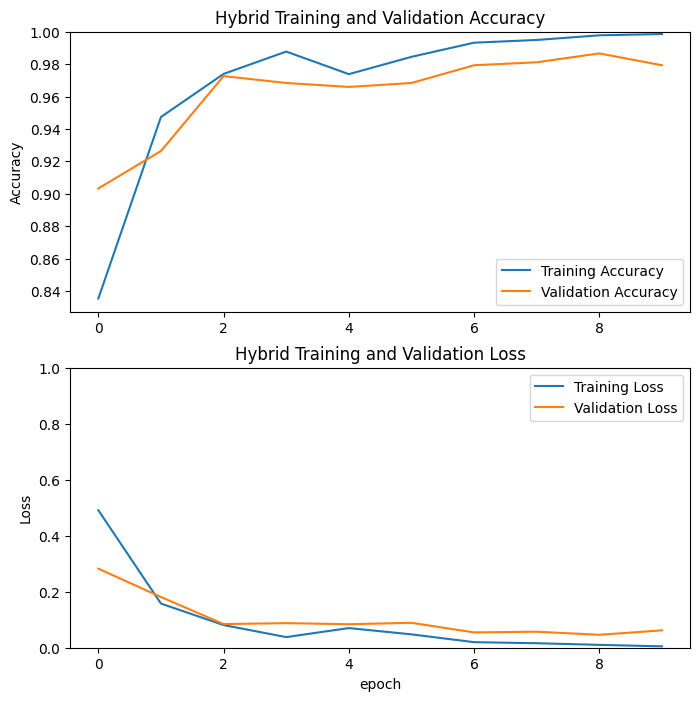

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Hybrid Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Hybrid Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━

2025-05-04 20:22:32.818403: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
class_names = ['healthy', 'mites_and_trips', 'nutritional', 'powdery mildew', 'cercospora']

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

                 precision    recall  f1-score   support

        healthy     0.9907    0.9551    0.9726       334
mites_and_trips     0.9400    0.9970    0.9676       330
    nutritional     0.9839    0.9735    0.9787       377
 powdery mildew     0.9900    0.9705    0.9801       305
     cercospora     0.9902    0.9967    0.9935       305

       accuracy                         0.9782      1651
      macro avg     0.9790    0.9785    0.9785      1651
   weighted avg     0.9788    0.9782    0.9782      1651



In [ ]:
conf_mat = confusion_matrix(y_true, y_pred)

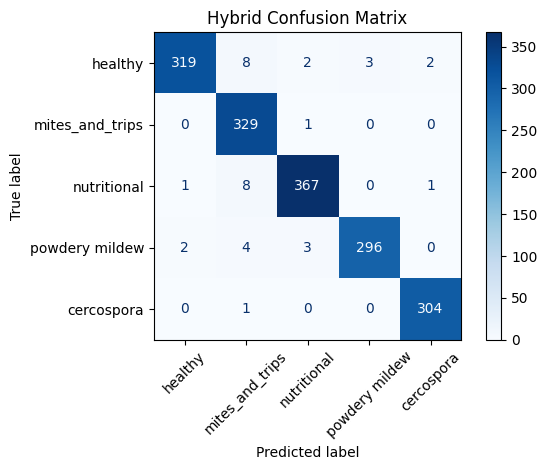

In [ ]:
class_names = ['healthy', 'mites_and_trips', 'nutritional', 'powdery mildew', 'cercospora']

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Hybrid Confusion Matrix')
plt.xticks(rotation=45)

# Save the plot as a PNG or PDF file
plt.tight_layout()
plt.savefig('hybrid_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

## **VGG16**

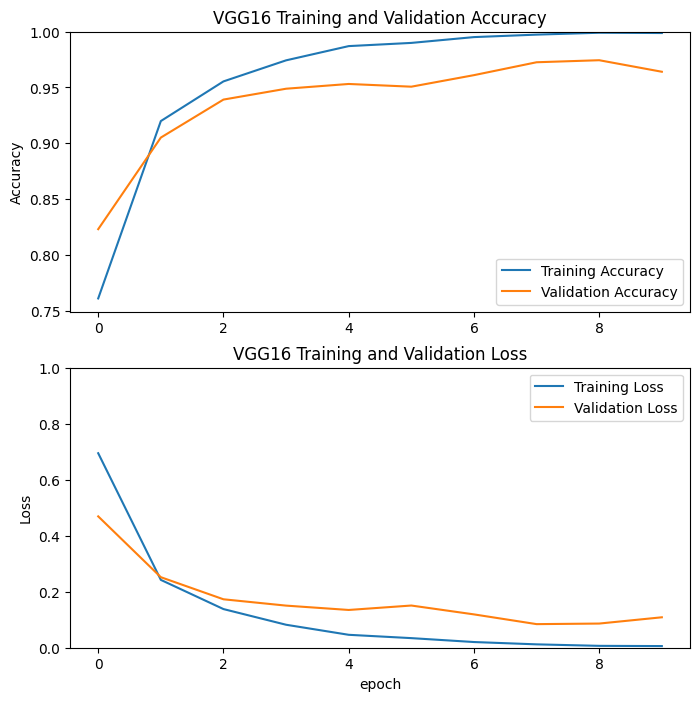

In [ ]:
acc_vgg16 = history_vgg16.history['accuracy']
val_acc_vgg16 = history_vgg16.history['val_accuracy']

loss_vgg16 = history_vgg16.history['loss']
val_loss_vgg16 = history_vgg16.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_vgg16, label='Training Accuracy')
plt.plot(val_acc_vgg16, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('VGG16 Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_vgg16, label='Training Loss')
plt.plot(val_loss_vgg16, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('VGG16 Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
y_true = []
y_pred_vgg16 = []

for images, labels in test_dataset:
    preds = model_vgg16.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred_vgg16.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred_vgg16 = np.array(y_pred_vgg16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
class_names = ['healthy', 'mites_and_trips', 'nutritional', 'powdery mildew', 'cercospora']

print(classification_report(y_true, y_pred_vgg16, target_names=class_names, digits=4))

                 precision    recall  f1-score   support

        healthy     0.9341    0.9760    0.9546       334
mites_and_trips     0.9840    0.9303    0.9564       330
    nutritional     0.9762    0.9788    0.9775       377
 powdery mildew     0.9513    0.9607    0.9560       305
     cercospora     0.9934    0.9902    0.9918       305

       accuracy                         0.9673      1651
      macro avg     0.9678    0.9672    0.9672      1651
   weighted avg     0.9678    0.9673    0.9673      1651



In [ ]:
conf_mat_vgg16 = confusion_matrix(y_true, y_pred_vgg16)

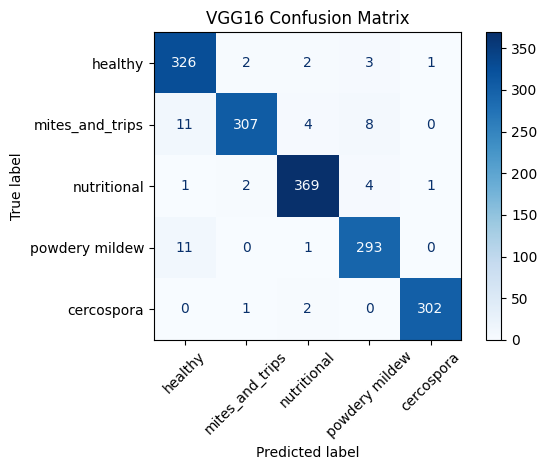

In [ ]:
class_names = ['healthy', 'mites_and_trips', 'nutritional', 'powdery mildew', 'cercospora']

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_vgg16, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('VGG16 Confusion Matrix')
plt.xticks(rotation=45)

# Save the plot as a PNG or PDF file
plt.tight_layout()
plt.savefig('vgg16_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

## **ResNet50**

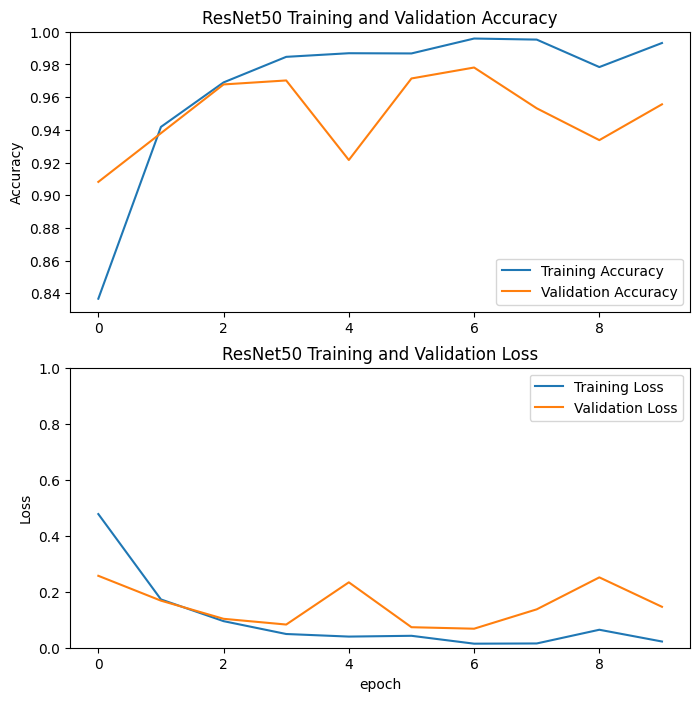

In [ ]:
acc_resnet50 = history_resnet50.history['accuracy']
val_acc_resnet50 = history_resnet50.history['val_accuracy']

loss_resnet50 = history_resnet50.history['loss']
val_loss_resnet50 = history_resnet50.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_resnet50, label='Training Accuracy')
plt.plot(val_acc_resnet50, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('ResNet50 Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_resnet50, label='Training Loss')
plt.plot(val_loss_resnet50, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('ResNet50 Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
y_true = []
y_pred_resnet50 = []

for images, labels in test_dataset:
    preds = model_resnet50.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred_resnet50.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred_vgg16 = np.array(y_pred_resnet50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
class_names = ['healthy', 'mites_and_trips', 'nutritional', 'powdery mildew', 'cercospora']

print(classification_report(y_true, y_pred_resnet50, target_names=class_names, digits=4))

                 precision    recall  f1-score   support

        healthy     0.9968    0.9341    0.9645       334
mites_and_trips     0.8479    0.9970    0.9164       330
    nutritional     0.9940    0.8727    0.9294       377
 powdery mildew     0.9522    0.9803    0.9661       305
     cercospora     0.9902    0.9902    0.9902       305

       accuracy                         0.9515      1651
      macro avg     0.9562    0.9549    0.9533      1651
   weighted avg     0.9569    0.9515    0.9519      1651



In [ ]:
conf_mat_resnet50 = confusion_matrix(y_true, y_pred_resnet50)

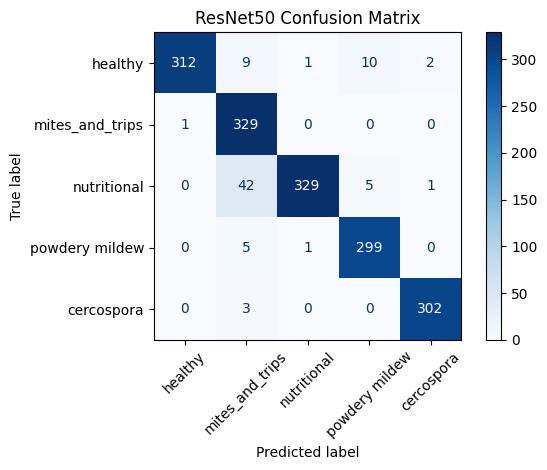

In [ ]:
class_names = ['healthy', 'mites_and_trips', 'nutritional', 'powdery mildew', 'cercospora']

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_resnet50, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('ResNet50 Confusion Matrix')
plt.xticks(rotation=45)

# Save the plot as a PNG or PDF file
plt.tight_layout()
plt.savefig('resnet50_confsuion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()